In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

load_dotenv()

OPENAI_API_BASE = os.environ.get("OPENAI_API_BASE")
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

LANGCHAIN_TRACING_V2 = os.environ.get("LANGCHAIN_TRACING_V2")
LANGCHAIN_ENDPOINT = 'https://api.smith.langchain.com'
LANGCHAIN_API_KEY = os.environ.get("LANGCHAIN_API_KEY")

llm = ChatOpenAI(model="qwen-max", temperature=0)

model_name = "C:\\Home\\Documents\\Projects\\models\\BAAI\\bge-large-en-v1.5"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
embedding_model = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

c:\Apps\miniconda3\envs\rag\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Multi-Representation

In [2]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | llm
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

In [4]:
# Vector Store

from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(host="localhost", port=6333)

client.create_collection(
    collection_name="summaries",
    vectors_config=VectorParams(size=1024, distance=Distance.COSINE),
)

vectorstore = QdrantVectorStore(
    client=client,
    collection_name="summaries",
    embedding=embedding_model,
)

In [5]:
import uuid
from langchain_core.documents import Document
from langchain.storage import InMemoryByteStore
from langchain.retrievers.multi_vector import MultiVectorRetriever


# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [6]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query,k=1)
sub_docs[0]

Document(metadata={'doc_id': '6b96ac7b-14b5-492c-9a13-862e3d383642', '_id': '8319f940-fa0a-4f2b-998d-df94d5de85bb', '_collection_name': 'summaries'}, page_content='The document discusses the concept and implementation of autonomous agents powered by Large Language Models (LLMs). These agents, which can be seen as general problem solvers, are built with LLMs at their core, complemented by planning, memory, and tool use components. The article is structured into several key sections:\n\n### Agent System Overview\n- **Planning**: Involves subgoal decomposition and self-reflection to break down complex tasks and learn from past actions.\n- **Memory**: Includes short-term and long-term memory, where short-term memory is akin to in-context learning and long-term memory leverages external vector stores for fast retrieval.\n- **Tool Use**: Agents can call external APIs to access information or perform actions that the model itself cannot.\n\n### Component One: Planning\n- **Task Decomposition*

In [7]:
retrieved_docs = retriever.get_relevant_documents(query,n_results=1)
print(retrieved_docs[0].page_content[0:500])







LLM Powered Autonomous Agents | Lil'Log







































Lil'Log

















|






Posts




Archive




Search




Tags




FAQ




emojisearch.app









      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


 


Table of Contents



Agent System Overview

Component One: Planning

Task Decomposition

Self-Reflection


Component Two: Memory

Types of Memory

Maximum Inner Product Search (MIPS


C:\Users\YC\AppData\Local\Temp\ipykernel_21580\3413505199.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query,n_results=1)


# RAPTOR

<function matplotlib.pyplot.show(close=None, block=None)>

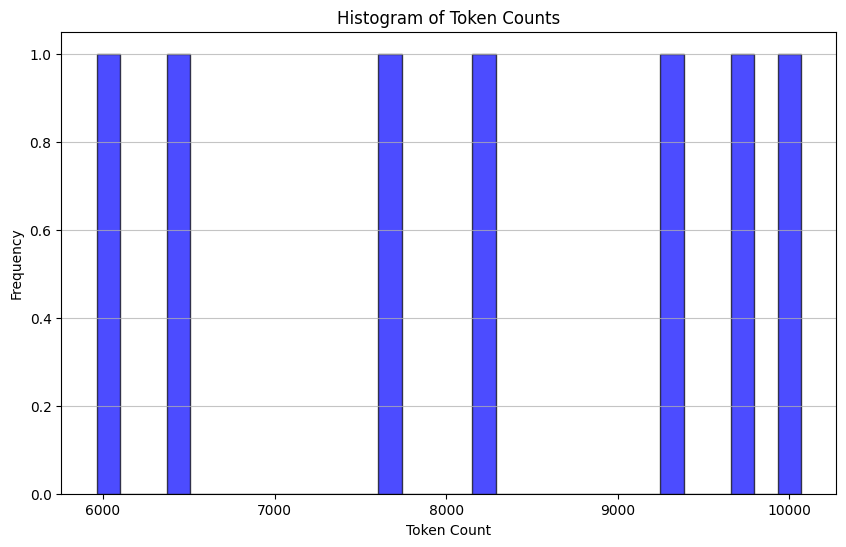

In [23]:
# Before running, please pip install tiktoken

import matplotlib.pyplot as plt
from dashscope import get_tokenizer  # dashscope version >= 1.14.0
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader


# Get the tokenizer object, currently only supports the Qwen series models
tokenizer = get_tokenizer('qwen-max')

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    # Split the string into tokens and convert to token ids
    num_tokens = tokenizer.encode(string)
    return len(num_tokens)

urls = [
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/agents/",
    "https://python.langchain.com/docs/tutorials/rag/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/",
    "https://python.langchain.com/docs/tutorials/sql_qa/",
    "https://python.langchain.com/docs/tutorials/summarization/",
    "https://python.langchain.com/docs/tutorials/graph/"
]

docs = []
for url in urls:
    loader = RecursiveUrlLoader(
        url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
    )
    docs.extend(loader.load())

docs_texts = [doc.page_content for doc in docs]

# Calculate the number of tokens for each document
counts = [num_tokens_from_string(doc_text) for doc_text in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [24]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(f"Num tokens in all context: {num_tokens_from_string(concatenated_content)}")

Num tokens in all context: 57457


In [25]:
# Doc texts split
from langchain.text_splitter import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)

In [49]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from 
# https://github.com/parthsarthi03/raptor/blob/master/raptor/cluster_tree_builder.py
# https://github.com/run-llama/llama_index/blob/main/llama-index-packs/llama-index-packs-raptor/llama_index/packs/raptor/clustering.py 
# (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embedding_model` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embedding_model.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of how to use LangChain build chatbot, agent and rag etc.
    
    Give a detailed summary of the documentation provided.
    
    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    llm_model = ChatOpenAI(model="qwen-plus", temperature=0)
    chain = prompt | llm_model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [37]:
for text in texts_split:
    if len(text) > 30720 or len(text) < 1:
        print(len(text))

In [50]:
# Build tree
# leaf_texts = docs_texts
leaf_texts = texts_split
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 8 clusters--
--Generated 1 clusters--


In [51]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(host="localhost", port=6333)

client.create_collection(
    collection_name="raptor",
    vectors_config=VectorParams(size=1024, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="raptor",
    embedding=embedding_model,
)

# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

vector_store.add_texts(texts=all_texts)

retriever = vectorstore.as_retriever()

In [59]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("How to build a RAG chatbot?")

'To build a RAG (Retrieval-Augmented Generation) chatbot, you need to integrate a large language model with a retrieval system that can fetch relevant information from an external knowledge base. This involves setting up a vector store for long-term memory and using efficient search algorithms like FAISS or HNSW for quick data retrieval. Additionally, fine-tuning the LLM to effectively use the retrieved information is essential for generating accurate and contextually relevant responses.'